# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Lucas Poblete
+ Jorge Riffo

**Correos Electrónicos:**

+ luc.poblete@duocuc.cl
+ j.riffo@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Carga de datos

In [4]:
import urllib.request
import os

files = [
    ("train-images-idx3-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz"),
    ("train-labels-idx1-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz"),
    ("t10k-images-idx3-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz"),
    ("t10k-labels-idx1-ubyte.gz", "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"),
]

for filename, url in files:
    if os.path.exists(filename):
        os.remove(filename)
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename} successfully!")


Downloaded train-images-idx3-ubyte.gz successfully!
Downloaded train-labels-idx1-ubyte.gz successfully!
Downloaded t10k-images-idx3-ubyte.gz successfully!
Downloaded t10k-labels-idx1-ubyte.gz successfully!


In [50]:
import gzip
import shutil
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical
# importación Adam   
from keras.optimizers import Adam

# Carga de imágenes

In [51]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


### Entradas y Salidas

In [52]:
N = X_train.shape[1]
C = y_train.shape[1]

# Muestra imágenes


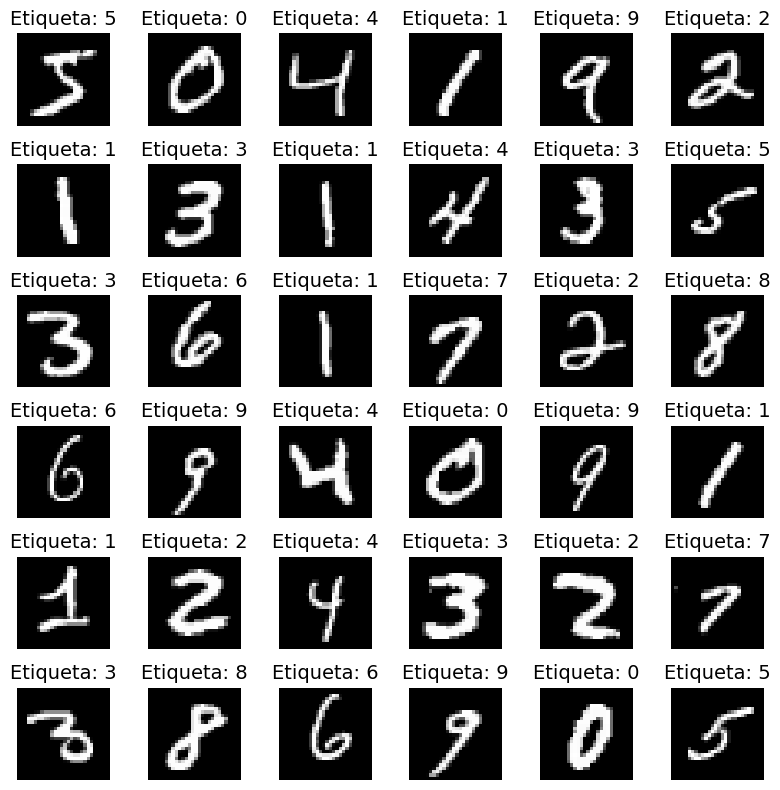

In [53]:
plt.figure(figsize=(8, 8))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Etiqueta: {np.argmax(y_train[i])}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

Clase     Cantidad  Porcentaje
--------------------------------
0         5923      9.87%
1         6742      11.24%
2         5958      9.93%
3         6131      10.22%
4         5842      9.74%
5         5421      9.04%
6         5918      9.86%
7         6265      10.44%
8         5851      9.75%
9         5949      9.92%
--------------------------------
Total     60000     100.00%   



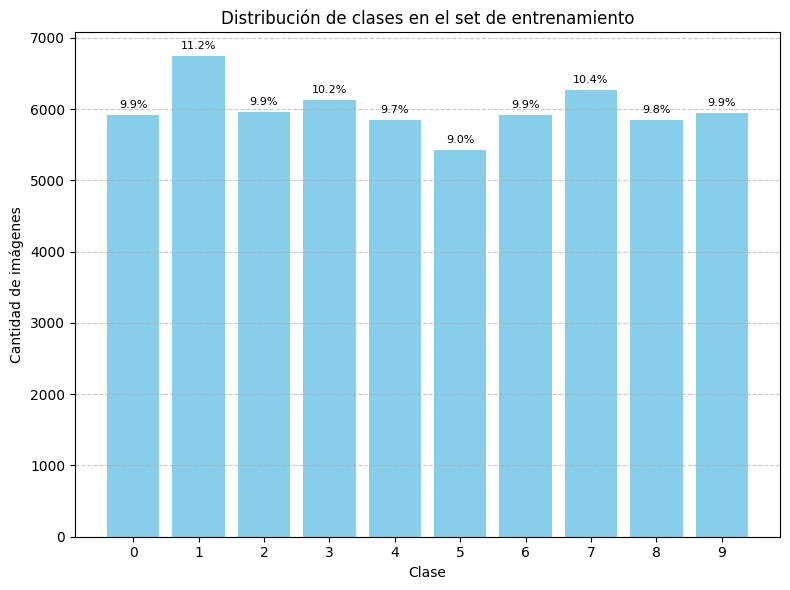

In [54]:
labels = np.argmax(y_train, axis=1)

# Contar cuántas imágenes hay de cada clase (0 al 9)
class_counts = np.bincount(labels)

# Calcular total
total = np.sum(class_counts)

print(f"{'Clase':<10}{'Cantidad':<10}{'Porcentaje':<10}")
print("-" * 32)

# Filas
for i, count in enumerate(class_counts):
    porcentaje = (count / total) * 100
    print(f"{i:<10}{count:<10}{porcentaje:.2f}%")

# Línea final con total
print("-" * 32)
print(f"{'Total':<10}{total:<10}{'100.00%':<10}\n")

# Graficar
plt.figure(figsize=(8, 6))
bars = plt.bar(range(10), class_counts, color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el set de entrenamiento")
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentaje sobre las barras
for bar, count in zip(bars, class_counts):
    porcentaje = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
             f"{porcentaje:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Métricas importantes

## Accuracy

Determina el porcentaje de clasificaciones de imagenes correctas del modelo.

- No es muy util en casos de desbalance de clases

Formula


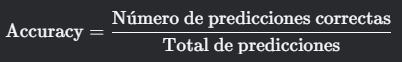

## Precision (Por clase)

Mide la calidad de las predicciones positivas

- De importancia cuando los FP son de importancia en el negocio

Formula

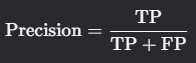

* TP (True Positives): Casos correctamente clasificados en la clase.
* FP (False Positives): Casos de otras clases erroneamente clasificados en esta.

## Recall (Por clase)

Capacidad de detectar una clase
- Crítico cuando los FN son de importancia

Formula

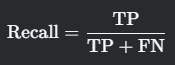

* TP (True Positives): Casos correctamente clasificados en la clase.
* FN (False Negatives): Casos de la clase que fueron erroneamente clasificados en otras.

## F1-score

Media armónica entre precision y Recall
- Util en balance entre FP y FN

Formula

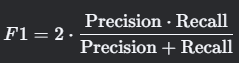

## Confusion Matrix

Muestra los valores reales vs los predichos en una matriz de todas las clases.
- Permite un analisis mas grafico de las predicciondes del modelo

Ejemplo:

## Elección de métrica para evaluar los distintos modelos de redes neuronales

Se ha elegido en este caso el Accuracy ya que el desbalance de clases no es tan relevante, es una métrica sencilla y mide la performance global del modelo. Siempre teniendo cuidado con mantener este desbalance proporcionalmente cuando se dividan los datos en datos para entrenamiento y testeo.

# Arquitecturas

Para el presente estudio de redes neuronales ocuparemos una arquitectura con 3 capas internas de 1024, 512 y 256 neuronas. Recordemos que cada capa debe tener un número de neuronas igual o menor a la anterior.

Se cambiaran los demas parametros para este estudio.

## Funciones (crear redes customizadas y graficos)

In [55]:
def crear_red_neuronal(
    N,                          # Dimension de entrada
    C,                          # Neuronas de salida (clases)
    activaciones,               # Lista de funciones de activación por capa (ej: ['relu', 'relu', 'relu', 'softmax'])
    neuronas=[512, 256, 128],  # Neuronas por capa oculta (por defecto: [1024, 512, 256])
    dropout=None,               # None o lista de tasas de dropout por capa (ej: [0.2, 0.3, 0.1])
    nombre="Red_Personalizada"  # Nombre de la red
):
    """
    Crea una red neuronal con:
    - Activaciones personalizadas por capa.
    - Dropout opcional en capas ocultas.
    - Nombre personalizado.
    """
    red = keras.Sequential(name=nombre)
    red.add(keras.layers.Input(shape=(N,), name='entrada'))

    for i, (n_neuronas, activacion) in enumerate(zip(neuronas, activaciones[:-1])):
        red.add(keras.layers.Dense(n_neuronas, activation=activacion))
        if dropout and i < len(dropout):  # Añadir dropout si se especifica
            red.add(keras.layers.Dropout(dropout[i]))

    # Capa de salida (activación final)
    red.add(keras.layers.Dense(C, activation=activaciones[-1]))

    return red

In [56]:
def plot_history(hist, name_model):

  # Crear figura con dos subplots horizontales
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  fig.suptitle(f'Evolución del Entrenamiento - {name_model}', fontweight="bold", fontsize=18)

  # --- Pérdida ---
  axs[0].plot(hist.history['loss'], label='Training Loss')
  axs[0].plot(hist.history['val_loss'], label='Validation Loss')
  axs[0].set_title('Pérdida', fontweight="bold", fontsize=16)
  axs[0].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[0].set_ylabel('Loss', fontweight="bold", fontsize=14)
  axs[0].legend()
  axs[0].grid(True)

  # --- Precisión ---
  axs[1].plot(hist.history['accuracy'], label='Training Accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='Validation Accuracy')
  axs[1].set_title('% Acierto', fontweight="bold", fontsize=16)
  axs[1].set_xlabel('Época', fontweight="bold", fontsize=14)
  axs[1].set_ylabel('Accuracy', fontweight="bold", fontsize=14)
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

## Activadores

Los activadores permiten a las redes neuronales agregar componentes no lineales

## Red Adam con activador relu

In [120]:
neuronas=[512, 256, 128]
activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1"

## Crear red
red_adamv1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [58]:
## Compilacion de la red
red_adamv1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Resumen de la red construida
red_adamv1.summary()

Model: "Red_Neuronal_Adam_V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento con 30 epocas y batch size 20

In [59]:
hist_redadamv1_1 = red_adamv1.fit(
        X_train, y_train,
        epochs=30,
        batch_size=20,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9031 - loss: 0.3110 - val_accuracy: 0.9671 - val_loss: 0.1020
Epoch 2/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9710 - loss: 0.0948 - val_accuracy: 0.9742 - val_loss: 0.0870
Epoch 3/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9800 - loss: 0.0627 - val_accuracy: 0.9671 - val_loss: 0.1235
Epoch 4/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9845 - loss: 0.0489 - val_accuracy: 0.9761 - val_loss: 0.0857
Epoch 5/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9880 - loss: 0.0372 - val_accuracy: 0.9704 - val_loss: 0.1163
Epoch 6/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9891 - loss: 0.0359 - val_accuracy: 0.9802 - val_loss: 0.0793
Epoch 7/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9914 - loss: 0.0280 - val_accuracy: 0.9772 - val_loss: 0.0826
Epoch 8/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9919 - loss: 0

In [121]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds = []
history_reds.append({
    'epocas': 30,
    'batch_size': 20,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_1.history['loss'][-1],
    'train_accuracy': hist_redadamv1_1.history['accuracy'][-1],
    'test_loss': hist_redadamv1_1.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_1.history['val_accuracy'][-1]
})

columnas = []
columnas.append(nombre_red)

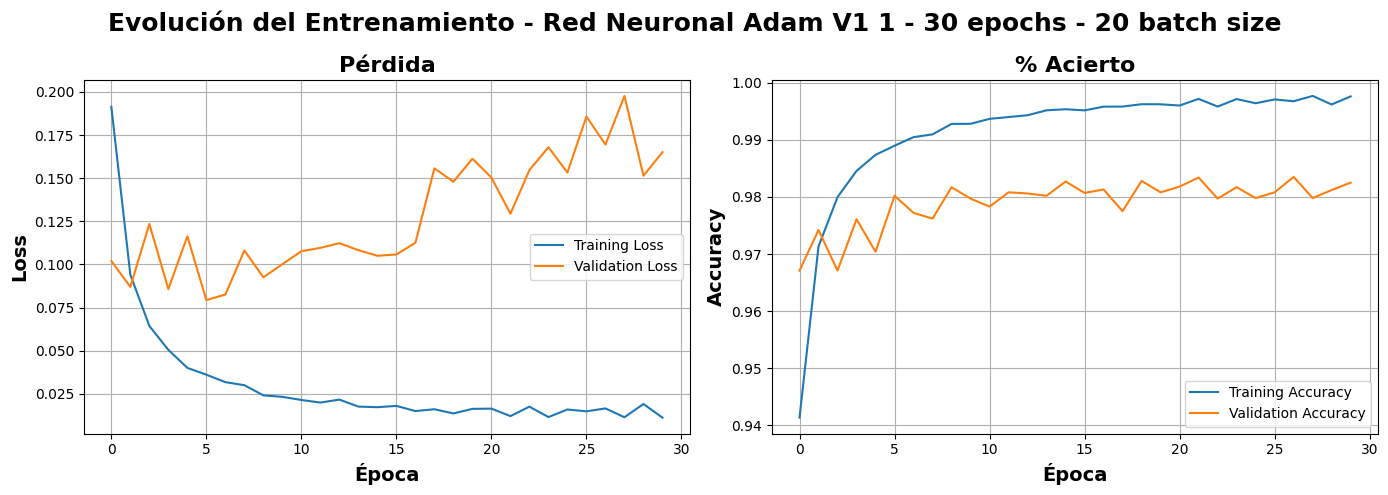

In [61]:
plot_history(hist_redadamv1_1, name_model="Red Neuronal Adam V1 1 - 30 epochs - 20 batch size")

### Entrenamiento con 30 epocas y batch size 60

In [ ]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1_2"

## Crear red
red_adamv1_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

red_adamv1_2.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


## Entrenamiento de la red
hist_redadamv1_2 = red_adamv1_2.fit(
        X_train, y_train,
        epochs=30,
        batch_size=60,
        validation_data=(X_test, y_test),
        verbose=1
    )

KeyboardInterrupt: 

In [125]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 30,
    'batch_size': 60,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_2.history['loss'][-1],
    'train_accuracy': hist_redadamv1_2.history['accuracy'][-1],
    'test_loss': hist_redadamv1_2.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

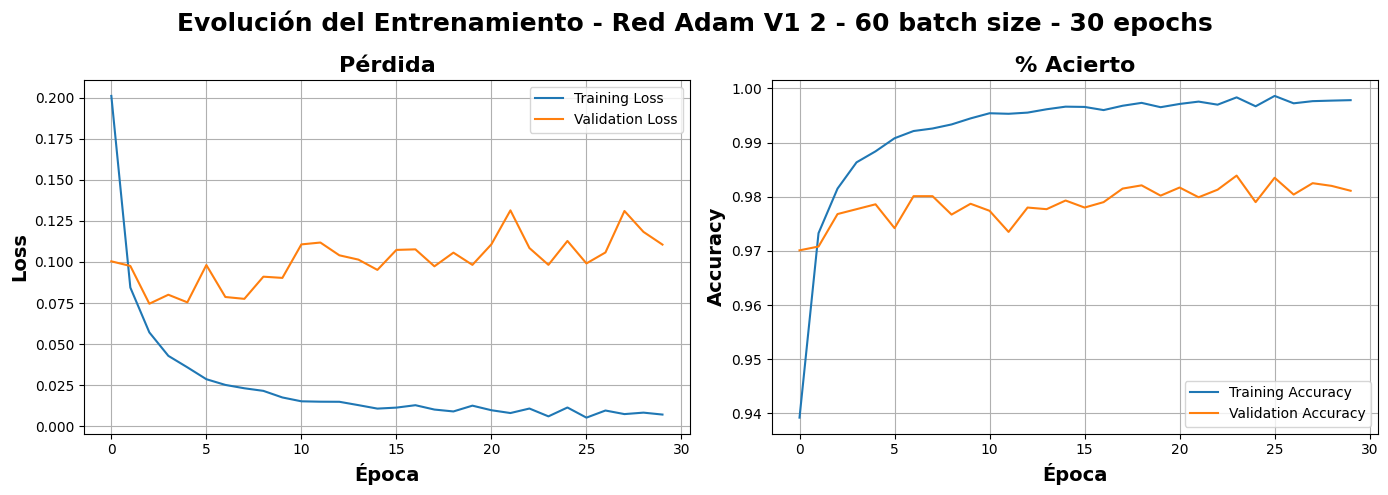

In [64]:
plot_history(hist_redadamv1_2, name_model="Red Adam V1 2 - 60 batch size - 30 epochs")

### Entrenamiento con 50 epocas y batch size 120

In [65]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V1_3"

## Descripción red
red_adamv1_3_descrip = "Optimizer: Adam \n Activation: Relu + Softmax \n Drop out: No \n Loss: Categorical crossentropy"

## Crear red
red_adamv1_3 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

red_adamv1_3.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_redadamv1_3 = red_adamv1_3.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8737 - loss: 0.4302 - val_accuracy: 0.9652 - val_loss: 0.1118
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9730 - loss: 0.0899 - val_accuracy: 0.9754 - val_loss: 0.0767
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9838 - loss: 0.0518 - val_accuracy: 0.9739 - val_loss: 0.0850
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9886 - loss: 0.0365 - val_accuracy: 0.9739 - val_loss: 0.0872
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9904 - loss: 0.0293 - val_accuracy: 0.9766 - val_loss: 0.0778
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9912 - loss: 0.0258 - val_accuracy: 0.9749 - val_loss: 0.0924
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9926 - loss: 0.0218 - val_accuracy: 0.9779 - val_loss: 0.0814
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9938 - loss: 0.0187 - val_accuracy: 0.

In [127]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_3.history['loss'][-1],
    'train_accuracy': hist_redadamv1_3.history['accuracy'][-1],
    'test_loss': hist_redadamv1_3.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_3.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

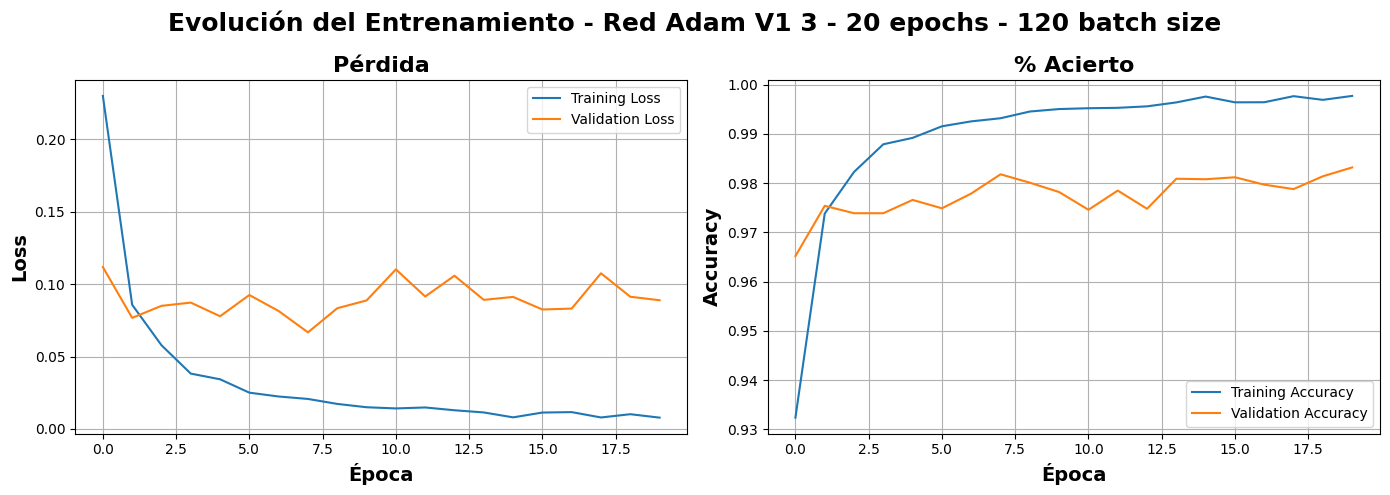

In [67]:
plot_history(hist_redadamv1_3, name_model='Red Adam V1 3 - 20 epochs - 120 batch size')

## Resultados de experimentación 1: Cambios en batch size y epocas

Para el Optimizador Adam, la configuración de arquitectura mas conveniente es la entrenada con 20 epocas y un batch size de 120, ya que en las demas requieren de mas recursos y se obtienen resultados muy similares.

## Experimentación 2:  Cambios en Learning rate

### Red Neuronal con optimizador Adam con learning rate = 0.1

Valor sobre el valor por default que es 0.001 en keras

In [128]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_1"

## Crear red
red_adamv2_1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [69]:
## Compilacion de la red para resetear pesos
red_adamv2_1.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.1),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_redadamv2_1 = red_adamv2_1.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

## Descripción red
red_adamv2_1_descrip = "Optimizer: Adam \n Activation: Relu + Softmax \n Drop out: No \n Loss: Categorical crossentropy \n Batch size: 120 \n Epochs: 50 \n Learnind rate: 0.1"

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1136 - loss: 22.0272 - val_accuracy: 0.1135 - val_loss: 2.3044
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1021 - loss: 2.3212 - val_accuracy: 0.1028 - val_loss: 2.3102
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1028 - loss: 2.3084 - val_accuracy: 0.0958 - val_loss: 2.3127
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1048 - loss: 2.3084 - val_accuracy: 0.1010 - val_loss: 2.3094
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1053 - loss: 2.3069 - val_accuracy: 0.1009 - val_loss: 2.3132
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1029 - loss: 2.3100 - val_accuracy: 0.1009 - val_loss: 2.3085
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1020 - loss: 2.3080 - val_accuracy: 0.1010 - val_loss: 2.3049
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1015 - loss: 2.3076 - val_accuracy: 0

In [129]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.1,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv2_1.history['loss'][-1],
    'train_accuracy': hist_redadamv2_1.history['accuracy'][-1],
    'test_loss': hist_redadamv2_1.history['val_loss'][-1],
    'test_accuracy': hist_redadamv2_1.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

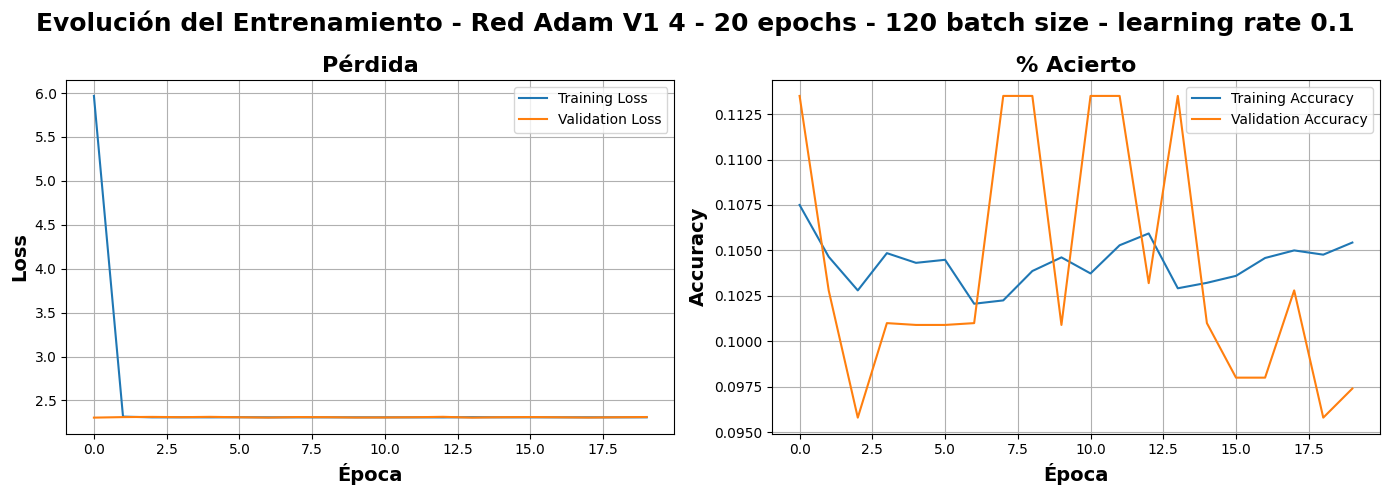

In [71]:
plot_history(hist_redadamv2_1, name_model='Red Adam V1 4 - 20 epochs - 120 batch size - learning rate 0.1')

### Red Neuronal con optimizador Adam con learning rate = 0.01

In [130]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_2"

## Crear red
red_adamv2_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [73]:
## Compilacion de la red para resetear pesos
red_adamv2_2.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv2_2 = red_adamv2_2.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8582 - loss: 0.4864 - val_accuracy: 0.9555 - val_loss: 0.1534
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9599 - loss: 0.1411 - val_accuracy: 0.9619 - val_loss: 0.1498
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9693 - loss: 0.1100 - val_accuracy: 0.9686 - val_loss: 0.1175
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9712 - loss: 0.1080 - val_accuracy: 0.9683 - val_loss: 0.1326
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9766 - loss: 0.0869 - val_accuracy: 0.9700 - val_loss: 0.1232
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9788 - loss: 0.0777 - val_accuracy: 0.9693 - val_loss: 0.1351
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9779 - loss: 0.0858 - val_accuracy: 0.9671 - val_loss: 0.1411
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9825 - loss: 0.0689 - val_accuracy: 0.

In [131]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_red_adamv2_2.history['loss'][-1],
    'train_accuracy': hist_red_adamv2_2.history['accuracy'][-1],
    'test_loss': hist_red_adamv2_2.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv2_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

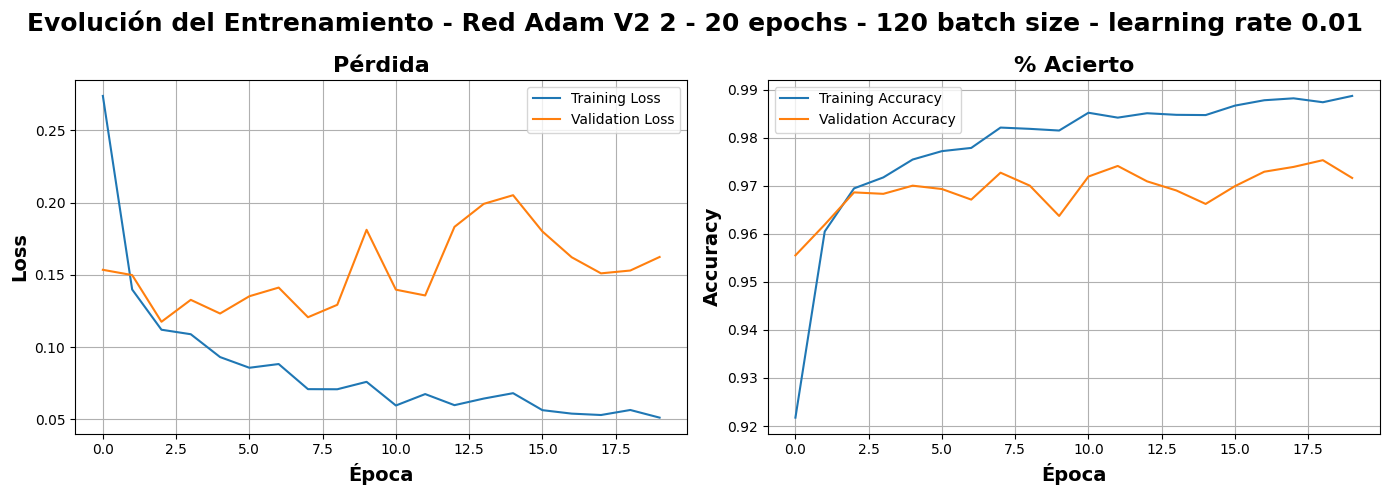

In [75]:
plot_history(hist_red_adamv2_2, name_model='Red Adam V2 2 - 20 epochs - 120 batch size - learning rate 0.01')

### Red Neuronal con optimizador Adam con learning rate = 0.001 (Valor por default)

In [ ]:
nombre_red = "Red_Neuronal_Adam_V2_3"

# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy de hist_redadamv1_3
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_redadamv1_3.history['loss'][-1],
    'train_accuracy': hist_redadamv1_3.history['accuracy'][-1],
    'test_loss': hist_redadamv1_3.history['val_loss'][-1],
    'test_accuracy': hist_redadamv1_3.history['val_accuracy'][-1]
})

columnas.append(nombre_red)


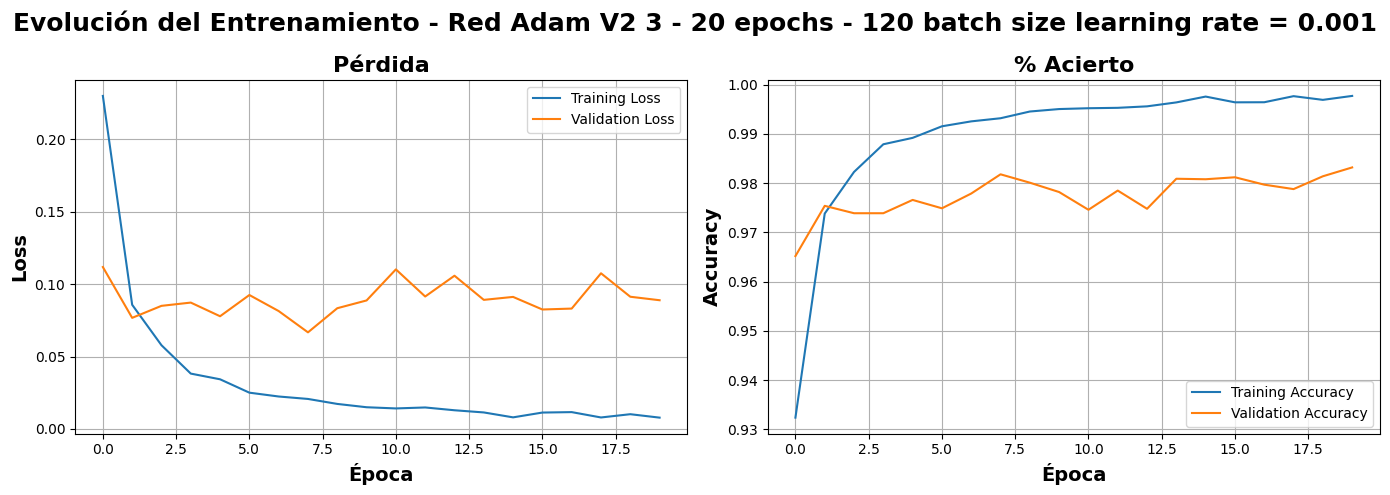

In [77]:
plot_history(hist_redadamv1_3, name_model='Red Adam V2 3 - 20 epochs - 120 batch size learning rate = 0.001')

In [149]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V2_4"

## Crear red
red_adamv2_4 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=None,
    nombre=nombre_red
)

In [150]:
## Compilacion de la red para resetear pesos
red_adamv2_4.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv2_4 = red_adamv2_4.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7531 - loss: 0.9923 - val_accuracy: 0.9351 - val_loss: 0.2221
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9408 - loss: 0.2074 - val_accuracy: 0.9543 - val_loss: 0.1574
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9565 - loss: 0.1493 - val_accuracy: 0.9600 - val_loss: 0.1343
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9664 - loss: 0.1198 - val_accuracy: 0.9675 - val_loss: 0.1057
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9732 - loss: 0.0934 - val_accuracy: 0.9713 - val_loss: 0.0953
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9789 - loss: 0.0739 - val_accuracy: 0.9731 - val_loss: 0.0890
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9822 - loss: 0.0626 - val_accuracy: 0.9747 - val_loss: 0.0805
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9857 - loss: 0.0518 - val_accuracy: 0.

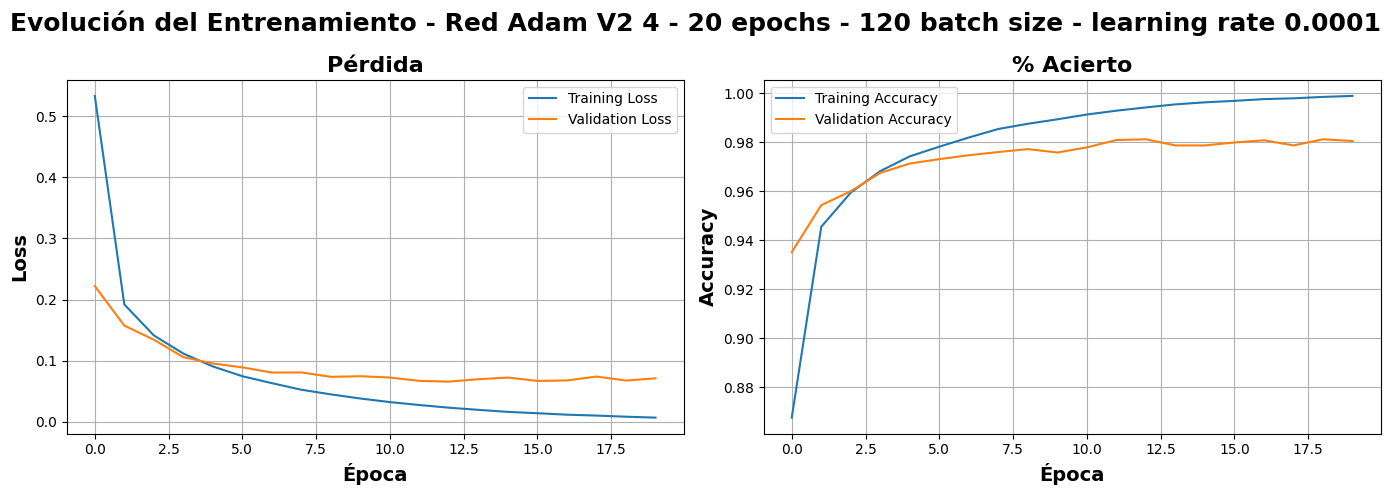

In [151]:
# graficamos la red
plot_history(hist_red_adamv2_4, name_model='Red Adam V2 4 - 20 epochs - 120 batch size - learning rate 0.0001')

In [152]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.0001,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': None,
    'train_loss': hist_red_adamv2_4.history['loss'][-1],
    'train_accuracy': hist_red_adamv2_4.history['accuracy'][-1],
    'test_loss': hist_red_adamv2_4.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv2_4.history['val_accuracy'][-1]
})
columnas.append(nombre_red)

## Resultados Experimentacion 2: Cambios en Learning Rate

Se puede apreciar que los cambios en learning rate afectan de manera significativa en el entrenamiento de modelos de redes neuronales. Podemos observar que el modelo con learning rate con valor de 0.1 tiene una performance muy mala, en comparacion con 0.01 y 0.001 en ambos con un rendimiento similar. El learning rate con el que nuestro modelo funciona de mejor manera es el por default, cuyo valor es 0.001.


# Experimentación 3: Cambios en dropout y activadores

En este caso veremos que sucede con la implementación de dropout, con activadores relu y leaky relu, observando como cambia el rendimiento del modelo de redes neuronales con distintas configuraciones.

## 1. Drop out + relu + softmax 

In [134]:
neuronas=[512, 256, 128]

activaciones = ['relu', 'relu', 'relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V3_1"
dropout = [0.2, 0.3, 0.1]  # Tasa de dropout por capa 

## Crear red
red_adamv3_1 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=dropout,
    nombre=nombre_red
)

In [82]:
## Compilacion de la red para resetear pesos
red_adamv3_1.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv3_1 = red_adamv3_1.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8335 - loss: 0.5304 - val_accuracy: 0.9573 - val_loss: 0.1641
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9362 - loss: 0.2459 - val_accuracy: 0.9558 - val_loss: 0.1917
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9422 - loss: 0.2350 - val_accuracy: 0.9595 - val_loss: 0.1589
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9437 - loss: 0.2314 - val_accuracy: 0.9633 - val_loss: 0.1528
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9449 - loss: 0.2290 - val_accuracy: 0.9664 - val_loss: 0.1353
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9493 - loss: 0.2036 - val_accuracy: 0.9624 - val_loss: 0.1455
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9509 - loss: 0.2107 - val_accuracy: 0.9650 - val_loss: 0.1487
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9470 - loss: 0.2268 - val_accuracy: 0.

In [135]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': dropout,
    'train_loss': hist_red_adamv3_1.history['loss'][-1],
    'train_accuracy': hist_red_adamv3_1.history['accuracy'][-1],
    'test_loss': hist_red_adamv3_1.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv3_1.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

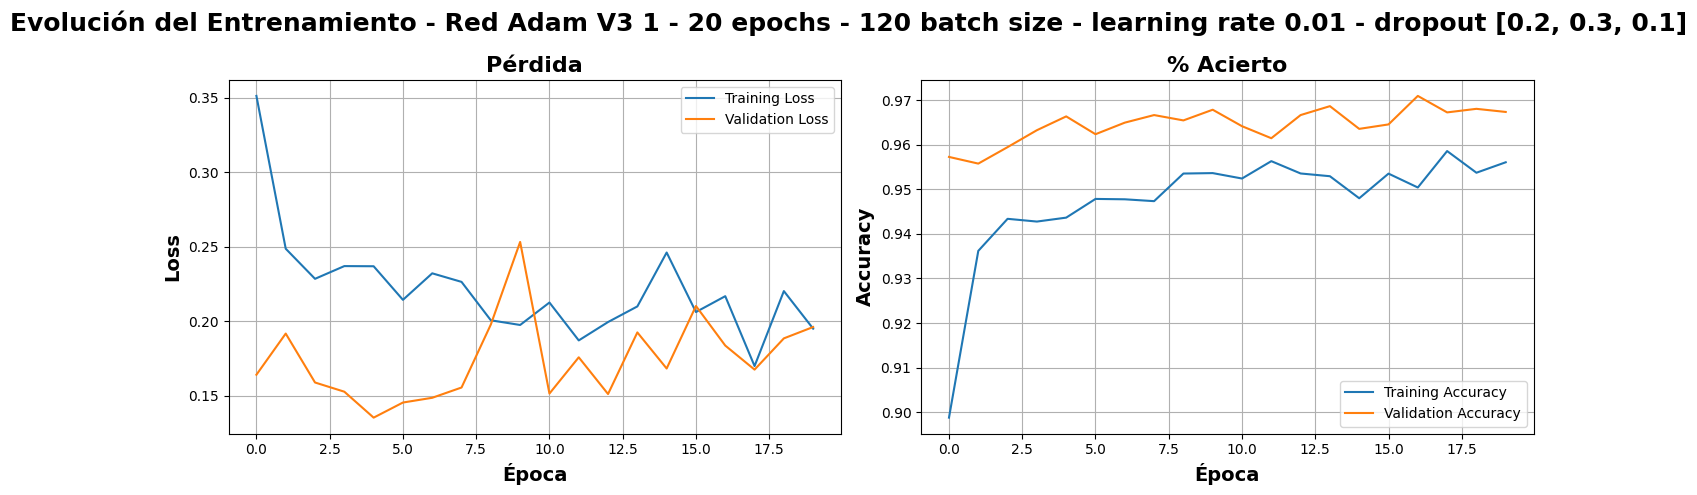

In [84]:
# graficamos el rendimiento de la red
plot_history(hist_red_adamv3_1, name_model='Red Adam V3 1 - 20 epochs - 120 batch size - learning rate 0.01 - dropout [0.2, 0.3, 0.1]')

## 2. Drop out + Leaky Relu + softmax 

In [136]:
neuronas=[512, 256, 128]

activaciones = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'softmax']  # Activaciones por capa
nombre_red = "Red_Neuronal_Adam_V3_2"
dropout = [0.2, 0.3, 0.1]  # Tasa de dropout por capa 

## Crear red
red_adamv3_2 = crear_red_neuronal(
    N=N,
    C=C,
    neuronas=neuronas,
    activaciones=activaciones,
    dropout=dropout,
    nombre=nombre_red
)

In [86]:
## Compilacion de la red para resetear pesos
red_adamv3_2.compile(
    loss= 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## Entrenamiento de la red
hist_red_adamv3_2 = red_adamv3_2.fit(
        X_train, y_train,
        epochs=20,
        batch_size=120,
        validation_data=(X_test, y_test),
        verbose=1
    )

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8080 - loss: 0.7022 - val_accuracy: 0.9294 - val_loss: 0.2530
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8835 - loss: 0.5502 - val_accuracy: 0.8889 - val_loss: 0.9768
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8674 - loss: 1.2334 - val_accuracy: 0.9361 - val_loss: 0.4159
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9118 - loss: 0.5427 - val_accuracy: 0.9401 - val_loss: 0.3120
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9294 - loss: 0.3732 - val_accuracy: 0.8467 - val_loss: 2.0952
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8546 - loss: 8.5053 - val_accuracy: 0.9464 - val_loss: 0.7228
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9279 - loss: 0.9067 - val_accuracy: 0.9358 - val_loss: 0.4263
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9394 - loss: 0.4815 - val_accuracy: 0.

In [137]:
# Añadir a lista epocas, batch_size, Learning_rate, activadores, loss_function, dropout,  perdida y accuracy en entrenamiento y en testeo
history_reds.append({
    'epocas': 20,
    'batch_size': 120,
    'learning_rate': 0.01,
    'activadores': activaciones,
    'loss_function': 'categorical_crossentropy',
    'dropout': dropout,
    'train_loss': hist_red_adamv3_2.history['loss'][-1],
    'train_accuracy': hist_red_adamv3_2.history['accuracy'][-1],
    'test_loss': hist_red_adamv3_2.history['val_loss'][-1],
    'test_accuracy': hist_red_adamv3_2.history['val_accuracy'][-1]
})

columnas.append(nombre_red)

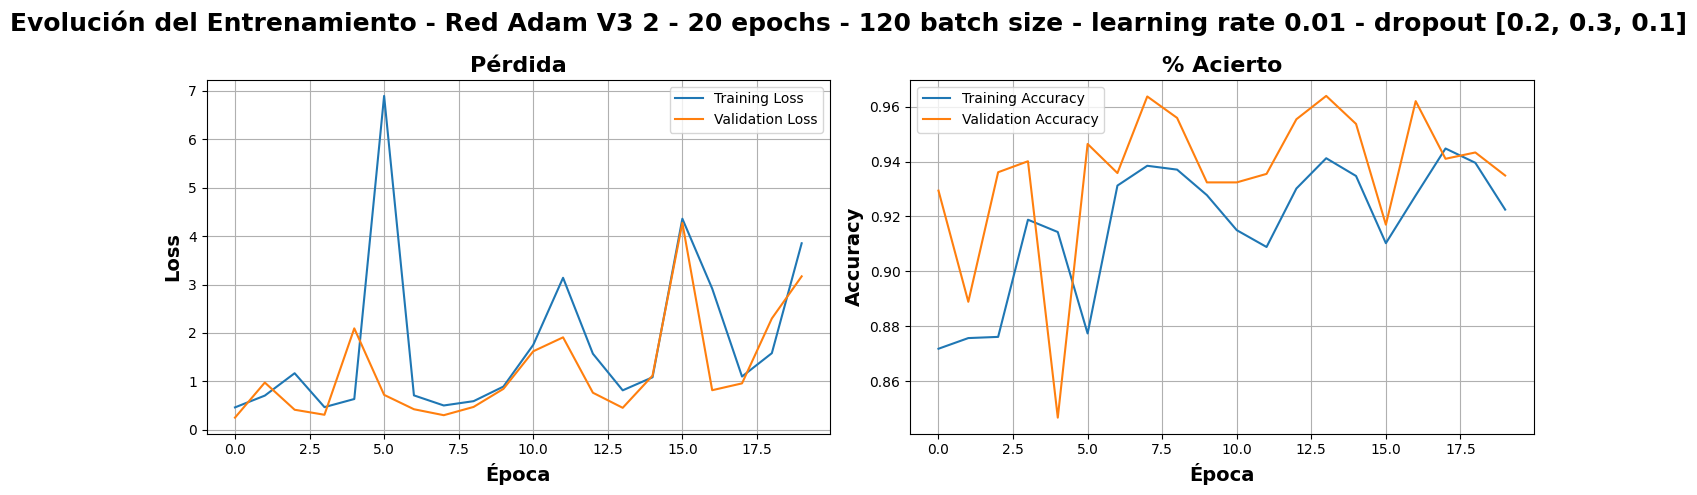

In [88]:
# graficamos el rendimiento de la red
plot_history(hist_red_adamv3_2, name_model='Red Adam V3 2 - 20 epochs - 120 batch size - learning rate 0.01 - dropout [0.2, 0.3, 0.1]')

In [ ]:
redes_df = pd.DataFrame(history_reds, index=range(1, len(history_reds) + 1)).T


redes_df.columns = columnas

redes_df = redes_df.T

redes_df

,epocas,batch_size,learning_rate,activadores,loss_function,dropout,train_loss,train_accuracy,test_loss,test_accuracy
Red_Neuronal_Adam_V1,30,20,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.011239,0.9976,0.165075,0.9825
Red_Neuronal_Adam_V1_2,30,60,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.00715,0.997833,0.110581,0.9811
Red_Neuronal_Adam_V1_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V2_1,20,120,0.1,"[relu, relu, relu, softmax]",categorical_crossentropy,None,2.307915,0.105433,2.311269,0.0974
Red_Neuronal_Adam_V2_2,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.051119,0.988667,0.162312,0.9716
Red_Neuronal_Adam_V2_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V3_1,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",0.195045,0.9561,0.196153,0.9674
Red_Neuronal_Adam_V3_2,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",3.851232,0.922483,3.168671,0.9349
Red_Neuronal_Adam_V2_4,20,120,0.0001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.006731,0.998917,0.071119,0.9805


In [156]:
# ordenar lista por mejor performance en testeo
redes_df = redes_df.sort_values(by='test_accuracy', ascending=False)
redes_df

,epocas,batch_size,learning_rate,activadores,loss_function,dropout,train_loss,train_accuracy,test_loss,test_accuracy
Red_Neuronal_Adam_V1_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V2_3,20,120,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.007814,0.997717,0.088835,0.9832
Red_Neuronal_Adam_V1,30,20,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.011239,0.9976,0.165075,0.9825
Red_Neuronal_Adam_V1_2,30,60,0.001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.00715,0.997833,0.110581,0.9811
Red_Neuronal_Adam_V2_4,20,120,0.0001,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.006731,0.998917,0.071119,0.9805
Red_Neuronal_Adam_V2_2,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,None,0.051119,0.988667,0.162312,0.9716
Red_Neuronal_Adam_V3_1,20,120,0.01,"[relu, relu, relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",0.195045,0.9561,0.196153,0.9674
Red_Neuronal_Adam_V3_2,20,120,0.01,"[leaky_relu, leaky_relu, leaky_relu, softmax]",categorical_crossentropy,"[0.2, 0.3, 0.1]",3.851232,0.922483,3.168671,0.9349
Red_Neuronal_Adam_V2_1,20,120,0.1,"[relu, relu, relu, softmax]",categorical_crossentropy,None,2.307915,0.105433,2.311269,0.0974
